#Hồi quy: Dự đoán hiệu suất nhiên liệu

Trong bài toán hồi quy, chúng ta dự đoán Ouput của 1 khoảng giá trị liên tục (ví dụ như giá cả hoặc xác suất). Trái với bài toán phân loại, khi mà chúng ta cần chọn 1 lớp giữa các lớp (ví dụ, 1 ảnh có chứa 1 loại quả táo hay cam, việc của chúng ta là xác định xem đó là loại quả nào).

Trong bài này ta sẽ sử dụng tập dữ liệu **Auto MPG** để xây dựng mô hình dự đoán hiệu suất nhiên liệu của ô tô vào cuối những năm 1970, đầu 1980. Để làm điều này, chúng ta sẽ cấp cho mô hình nhiều dữ liệu về ô tô trong thời gian đó. Dữ liệu này bao gồm: xi-lanh, chuyển vị, mã lực, và trọng lượng.

Chúng ta sẽ sử dụng API **tf.keras** như những bài trước.

In [0]:
# Use seaborn for pairplot
!pip install -q seaborn

In [15]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


#Tập dữ liệu Auto MPG

Tập dữ liệu này đã có sẵn trên [UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/), chúng ta chỉ cần tải về và sử dụng.

Đầu tiên tải về tập dữ liệu:


In [16]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

Nhập dữ liệu vào:

In [17]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


**Tiền xử lý dữ liệu**

Tập dữ liệu chứa một vài giá trị không xác định.

In [18]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Để bài toán đơn giản hơn, ta sẽ bỏ một số hàng đi.

In [0]:
dataset = dataset.dropna()

Cột **Origin** không phải là dạng số, vì vậy ta sẽ biến đổi nó 1 chút:

In [0]:
origin = dataset.pop('Origin')

In [21]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


**Chia dữ liệu ra 2 phần Training và Testing**

Bây giờ chúng ta sẽ chia dữ liệu ra thành 2 phần: tập Training và tập Testing. Ta sẽ dùng tập Testing để đánh giá sau khi mô hình đã được train.



In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

**Phân tích dữ liệu**

Thử vẽ 1 biểu đồ biểu thị mối quan hệ giữa các cặp đặc tính trong tập dữ liệu:

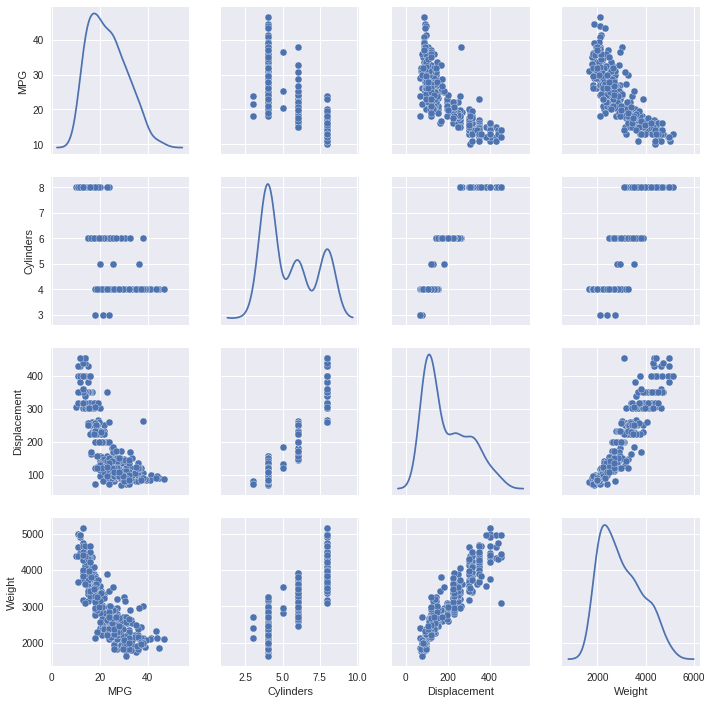

In [23]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Cũng thử nhìn vào thống kê tổng thế:

In [24]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


**Tách các tính năng từ nhãn**

Tách các giá trị đích, hoặc các nhãn, từ các tính năng. Các nhãn này chính là giá trị mà ta sẽ train mô hình để thực hiện việc dự đoán.


In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

**Chuẩn hóa dữ liệu**

Khối **train_stats** ở trên cho ta thấy sự sai khác giữa các đặc tính. Chúng ta sẽ chuẩn hóa các đặc tính sử dụng các phạm vi khác nhau. Mặc dù mô hình có thể không có tính năng chuẩn hóa khiến việc train trở nên khó khăn hơn, và nó khiến mô hình kết quả phụ thuộc vào việc chọn unit được sử dụng trong input.


In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Dữ liệu sau khi được chuẩn hóa sẽ được đem đi để train mô mình.

#Mô hình

**Xây dựng mô hình**

Bây giờ, ta dùng mô hình **Sequential** với 2 lớp ẩn kết nối dày đặc, và 1 lớp output trả về 1 giá trị hoặc 1 khoảng giá trị. Các bước xây dựng mô hình được gói gọn trong 1 hàm **build_model**, sau đó ta sẽ thiết kế mô hình thứ 2.

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [28]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


**Phân tích mô hình**

Sử dụng phương thức **.summary** để theo dõi chi tiết các đặc điểm của mô hình:

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Bây giờ chúng ta thử kiểm tra xem mô hình hoạt động như thế nào. Lấy 10 ví dụ từ tập Training và gọi hàm **model.predict** trên nó:

In [30]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.10419407],
       [-0.04453819],
       [ 0.09085366],
       [ 0.08594301],
       [-0.12548998],
       [ 0.11793849],
       [-0.12690832],
       [-0.32842794],
       [ 0.12859443],
       [ 0.02518652]], dtype=float32)

Mô hình có vẻ như đã xuất ra được kết quả như ta mong đợi.

**Train mô hình**

Train mô hình với 1000 kỳ, và ghi lại quá trình cùng độ chính xác bằng đối tượng **history**.



In [31]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

Phân tích quá trình training của mô hình sử dụng đặc tính được lưu trong đối tượng **history**.

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.479117,1.004110,2.479117,8.575069,2.189096,8.575069,995
996,2.714785,1.098821,2.714785,8.265335,2.107248,8.265334,996
997,2.522061,0.998929,2.522060,8.274368,2.127279,8.274367,997
998,2.571236,1.062845,2.571236,8.666835,2.201984,8.666835,998
999,2.623425,1.058711,2.623425,8.399400,2.115349,8.399401,999


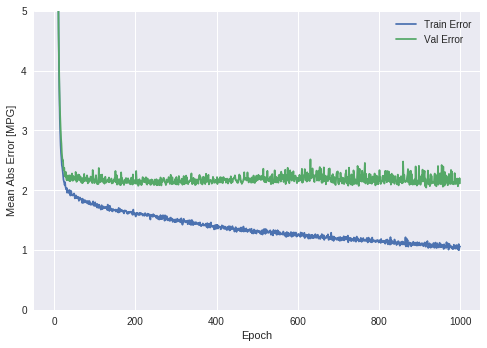

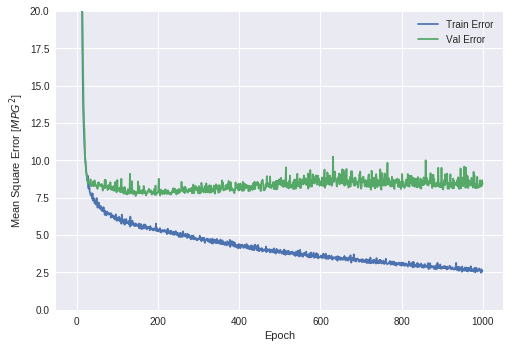

In [33]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Đồ thị này cho ta thấy đã có một chút cải thiện, hoặc thậm chí trong 100 kỳ đầu tiên, lỗi xác nhận đã giảm cực kỳ nhanh. Giờ cùng thử cập nhật hàm **model.fit** để tự động dừng train khi điểm xác nhận không ghi nhận được sự cải tiến đáng kể nào nữa. Ta sẽ dùng 1 hàm callback **EarlyStopping** để kiểm tra điều kiện train trong từng kỳ một. Nếu một vài kỳ trôi qua mà không thấy tiến triển, chúng ta sẽ dừng ngay để tiết kiệm tài nguyên máy tính.




...........................................................

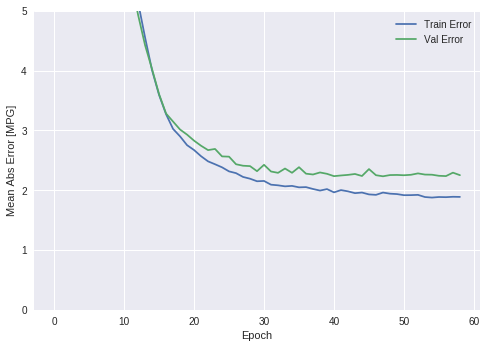

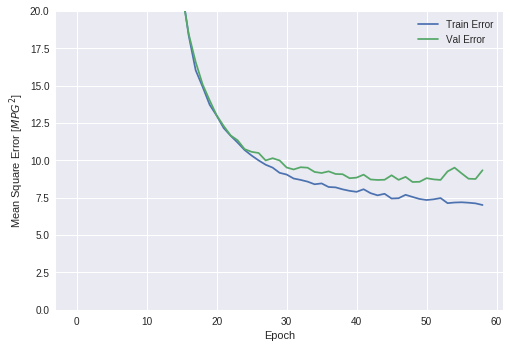

In [34]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

Đồ thị trên cho thấy lỗi trung bình thường ở loanh quanh ở mức +/-2 MPG.

Bây giờ chúng ta sẽ thử xem mô hình hoạt động tốt hay không bằng cách sử dụng bộ dữ liệu Testing.

In [35]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  2.03 MPG


**Dự đoán**

Cuối cùng, ta sẽ dự đoán giá trị MPG bằng việc sử dụng bộ Testing:

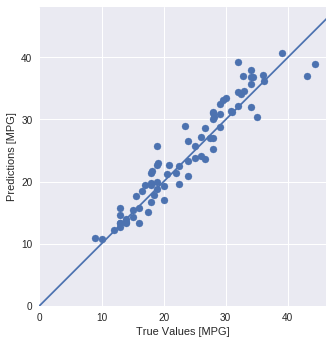

In [36]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Có thể thấy mô hình của chúng ta đưa ra dự đoán khá là chính xác.

Hãy thử xem qua biểu đồ phân bố lỗi:

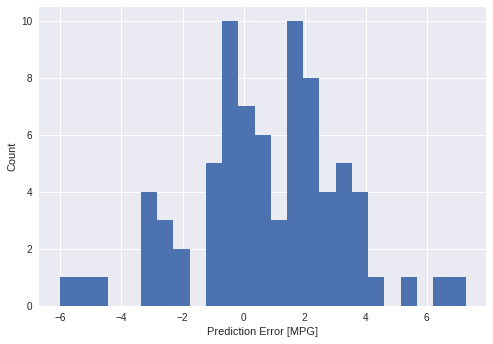

In [37]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

#Kết luận

Bài viết này giới thiệu 1 vài kỹ thuật để xử lý bài toán hồi quy.

* Mean Squared Error (MSE) là một hàm mất mát thông dụng được sử dụng cho bài toán hồi quy (khác với Different Loss Function được sử dụng cho bài toán phân loại).

* Tương tự, số liệu dùng để đánh giá trong bài toán hồi quy có khác so với bài toán phân loại. Một số liệu thông thường trong hồi quy là Mean Absolute Error (MAE).

* Khi các dữ liệu đầu vào có giá trị trong 1 khoảng, mỗi đặc tính sẽ được thu gọn lại trong 1 phạm vi bằng nhau.

* Nếu ta không có quá nhiều dữ liệu Training, có một kỹ thuật ưu tiên mạng với ít lớp ẩn sẽ tránh được tình trạng overfitting.

* Một kỹ thuật nữa để tránh overfitting là dừng train sớm khi nhận thấy mạng không được cải tiến qua các kỳ.